In [1]:
# import standard numerical modules
import numpy as np
import math
import tensorflow as tf
import gc

import DCTR


2024-05-07 11:32:28.171658: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-05-07 11:32:28.171708: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
data_dir = '../Data/'


In [3]:
# Load pre-normed Datasets: MiNNLO: X1 | POWHEG hvq: X0
# only contain tt-pair; every event has order: 
# tt-pair, top, anti-top
# every particle has arguments: 
# [pt, y, phi, mass, eta, E, PID, w, theta]
# [0 , 1, 2  , 3   , 4  , 5, 6  , 7, 8    ]

# POWHEG hvq
# plotting data; different from training data
X0_plt = []
X0_plt = DCTR.load_dataset(f'{data_dir}/POWHEG_hvq/13TeV/03-04_converted_lhe.npz', i=3)[:9553938] # 9553938 num of MiNNLO samples
print('POWHEG hvq all particles X0_plt.shape: '+str(X0_plt.shape))

X0_test = []
X0_test = DCTR.load_dataset(f'{data_dir}/POWHEG_hvq/13TeV/03-04_normed_converted_lhe.npz', i=3)[:9553938]
print('POWHEG hvq all particles X0_test.shape: '+str(X0_test.shape))


POWHEG hvq all particles X0_plt.shape: (9553938, 3, 9)
POWHEG hvq all particles X0_test.shape: (9553938, 3, 9)


In [4]:
# MiNNLO
# plotting data
X1_plt = []
X1_plt = DCTR.load_dataset(f'{data_dir}/MiNNLO/converted_with_13TeV_NLO/converted_lhe.npz', i=3)
print('MiNNLO all particles X1_plt.shape: '+str(X1_plt.shape))


MiNNLO all particles X1_plt.shape: (9553938, 3, 9)


In [5]:
# get event generator weights

X0_plt_wgt = X0_plt[:, 0, 7].copy()
X1_plt_wgt = X1_plt[:, 0, 7].copy()


In [6]:
# delete energy from (normalized) testing dataset, since the neural network was trained without these parameters
X0_test = np.delete(X0_test, 5, -1)

# delete eta
X0_test = np.delete(X0_test, 4, -1)

# garbage collection after deleting to clear memory asap
print(gc.collect())


194


2024-05-07 11:40:26.441146: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2024-05-07 11:40:26.442594: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2024-05-07 11:40:26.444116: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (finn-ThinkPad-T540p): /proc/driver/nvidia/version does not exist
2024-05-07 11:40:26.508683: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-07 11:40:30.141657: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 5732362

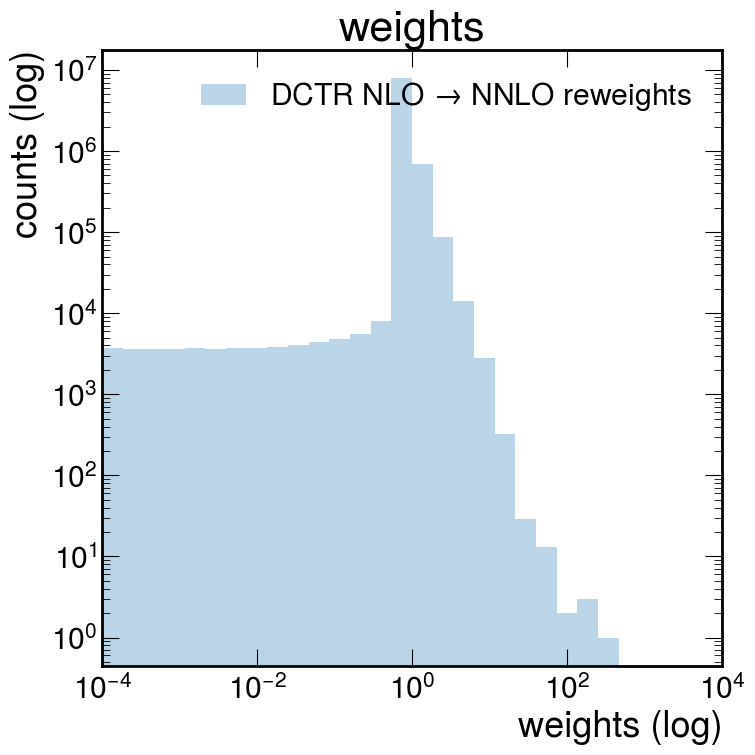

In [7]:
model = './train_20240504/super_epoch_18/run_4/s-18_b-131072_r-4.tf' # path to previously trained model (in .tf format (folder))

''' # save weights to .h5 file
dctr = tf.keras.models.load_model(model)
dctr.save('best_model_weights.h5')
'''

# calculate rwgt
with tf.device('CPU'):
    dctr_rwgt = DCTR.get_rwgt([model], X0_test) # .tf models also include network architecture. get_rwgt() sets up the network for the (list of) models, then calls predict_weights() like in DCTR_notebook_OLD_14-to-13TeV notebook
# plot and check dctr rwgt
wgts = [(dctr_rwgt[0], r'DCTR NLO $\to$ NNLO reweights')]
DCTR.plot_weights(wgts, start = 0.0001, stop = 10000)

# apply orginal generator weights to rwgt
rwgt = np.multiply(dctr_rwgt[0], X0_plt_wgt)


In [8]:
# check weights
print(f'X0_plt_wgt (min, max, mean): {min(X0_plt_wgt), max(X0_plt_wgt), np.mean(X0_plt_wgt)}')
print(f'X1_plt_wgt (min, max, mean): {min(X1_plt_wgt), max(X1_plt_wgt), np.mean(X1_plt_wgt)}')
print(f'X0 rwgt (min, max, mean): {min(rwgt), max(rwgt), np.mean(rwgt)}')


X0_plt_wgt (min, max, mean): (-692.465, 692.465, 686.4671955083866)
X1_plt_wgt (min, max, mean): (-103.245, 103.245, 83.13098417846136)
X0 rwgt (min, max, mean): (-6197.948192975998, 260261.94025158693, 558.21360960117)


In [9]:
# setup args for plotting
args = [(X1_plt, X1_plt_wgt, 'NNLO (MiNNLO)'),
        (X0_plt, X0_plt_wgt, 'NLO (hvq)'),
        (X0_plt, rwgt, 'dctr reweighted')]


# Paper Plots

'texgyreheros-bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-italic.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


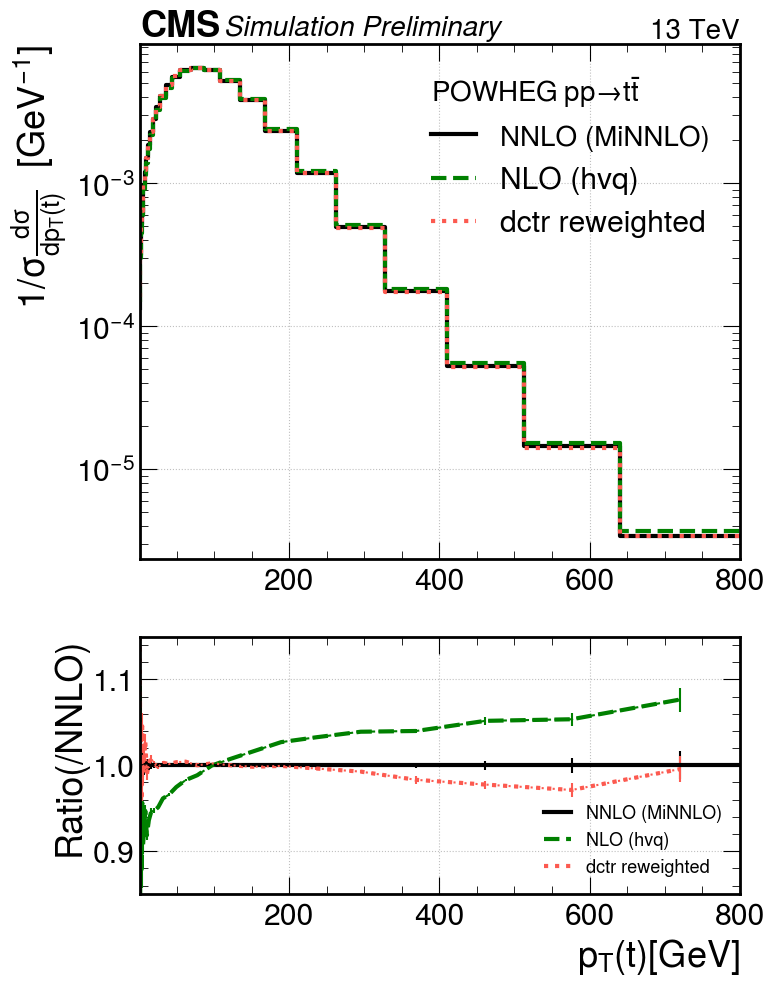

In [11]:
# p_t(t) log binning
log_bins = np.logspace(np.log10(1), np.log10(800), 31)
DCTR.plot_ratio_cms(args, arg_index=0, part_index=1, bins=log_bins, y_scale='log', ratio_ylim=[0.85, 1.15], pythia_text=r'$POWHEG \; pp \to  t\bar{t}$', save_prefix = 'no-mean_log_0800_31')


'texgyreheros-bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-italic.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


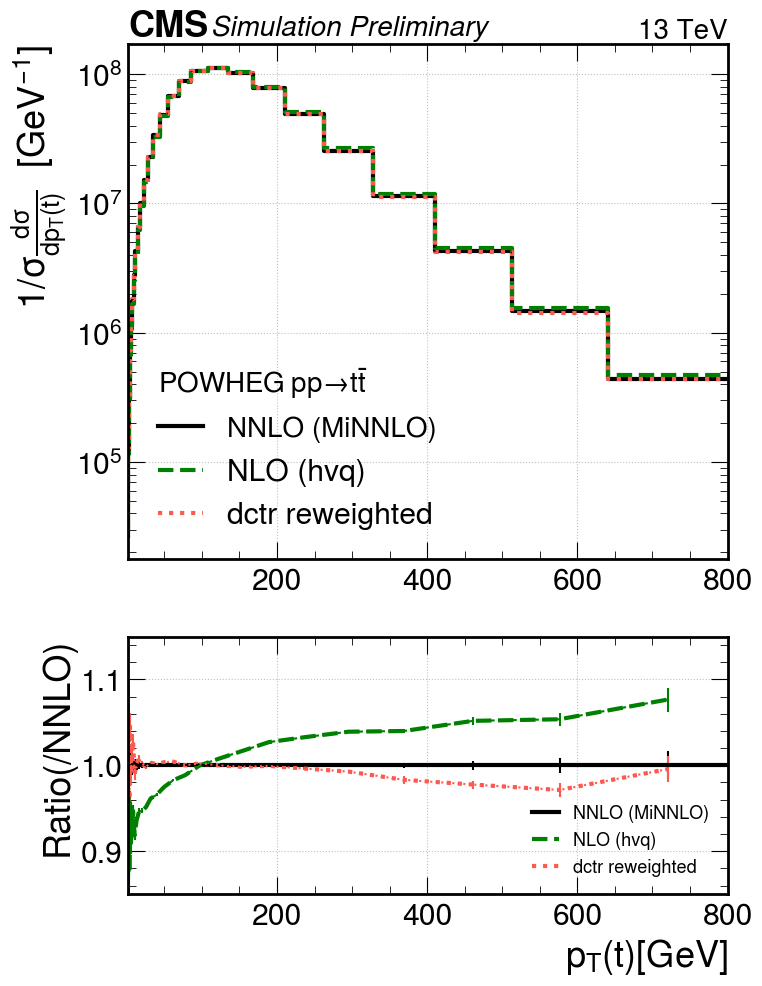

In [12]:
# p_t(t) log binning
log_bins = np.logspace(np.log10(1), np.log10(800), 31)
DCTR.plot_ratio_cms(args, arg_index=0, part_index=1, bins=log_bins, y_scale='log', ratio_ylim=[0.85, 1.15], pythia_text=r'$POWHEG \; pp \to  t\bar{t}$', save_prefix = 'no-mean_log_0800_31', density = False)


'texgyreheros-bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-italic.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


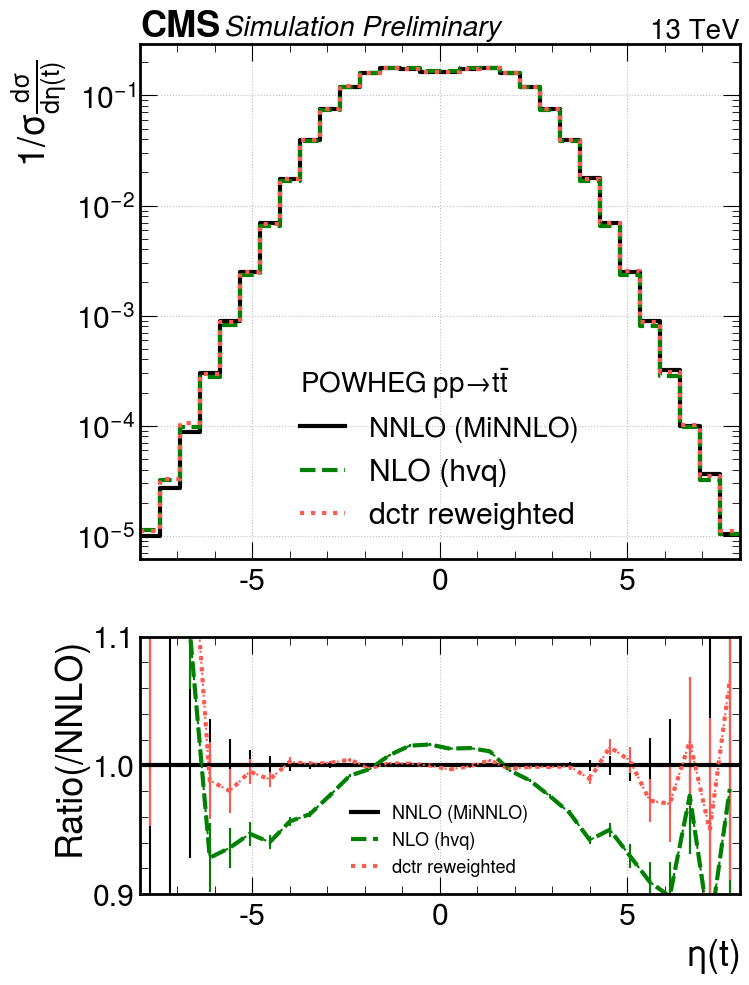

In [13]:
# eta(t) +/- 8
lin_bins = np.linspace(-8, 8, 31)
DCTR.plot_ratio_cms(args, arg_index=4, part_index=1, bins=lin_bins, y_scale='log', ratio_ylim=[0.90, 1.10], pythia_text=r'$POWHEG \; pp \to  t\bar{t}$', save_prefix = 'no-mean_lin_pm8_31')


'texgyreheros-bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-italic.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


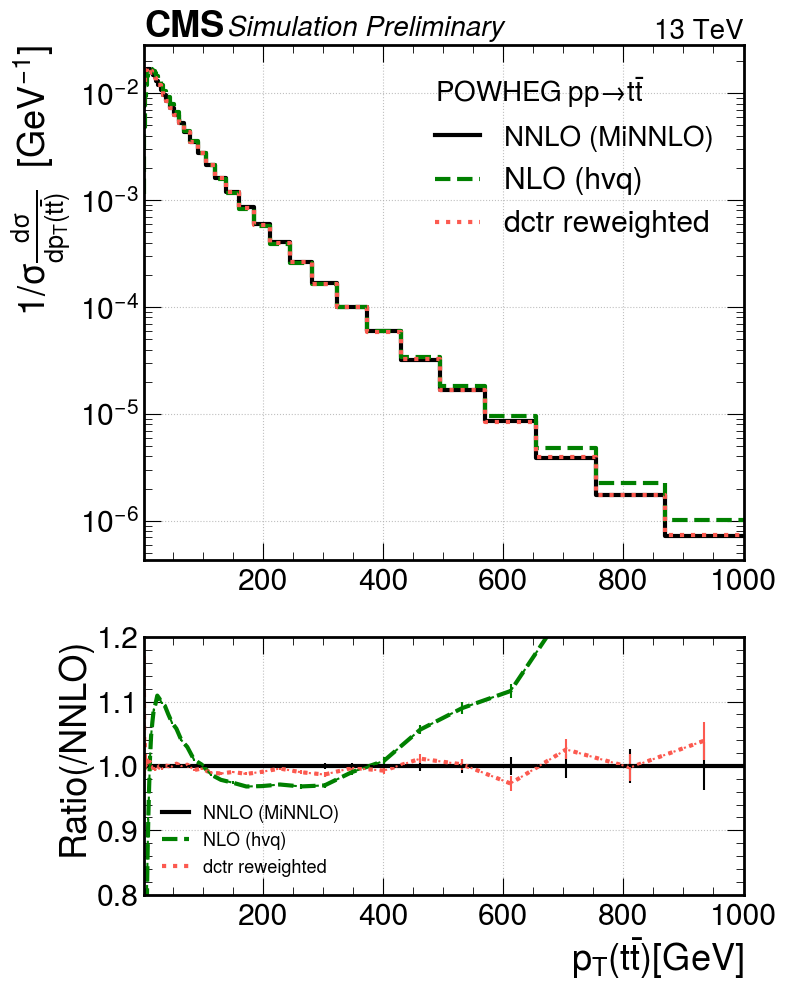

In [14]:
# p_t(tt) log binning
log_bins = np.logspace(np.log10(1), np.log10(1000), 50)
DCTR.plot_ratio_cms(args, arg_index=0, part_index=0, bins=log_bins, y_scale='log', ratio_ylim=[0.80, 1.20], pythia_text=r'$POWHEG \; pp \to  t\bar{t}$', save_prefix = 'no-mean_log_1000_50')


'texgyreheros-bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-italic.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


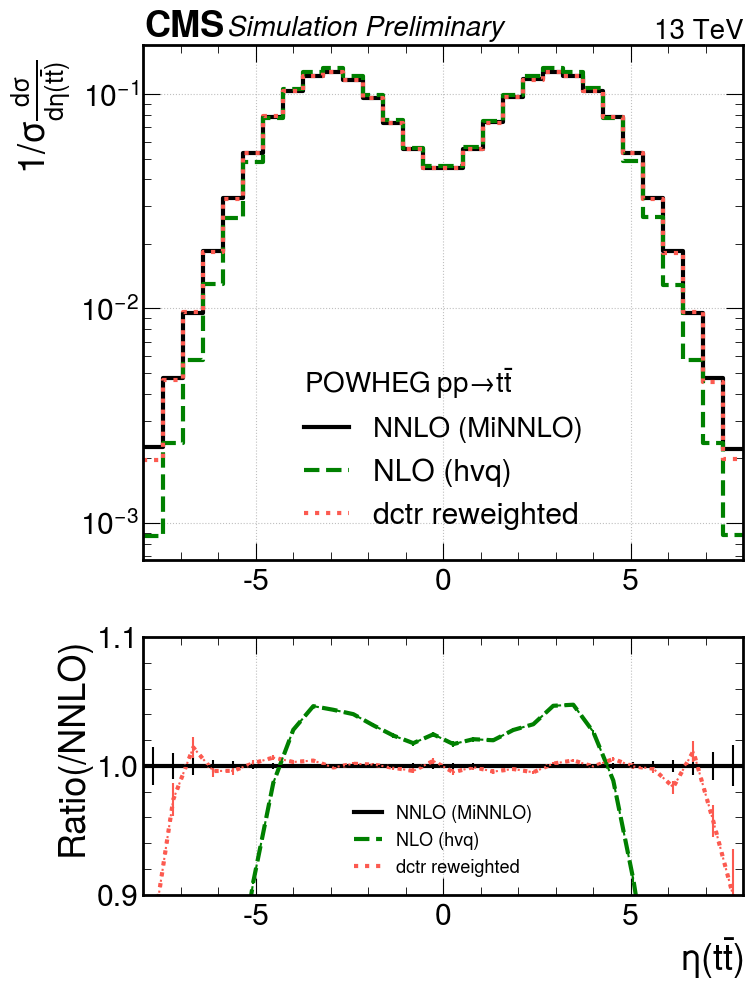

In [15]:
# eta(tt) +/- 8
lin_bins = np.linspace(-8, 8, 31)
DCTR.plot_ratio_cms(args, arg_index=4, part_index=0, bins=lin_bins, y_scale='log', ratio_ylim=[0.90, 1.10], pythia_text=r'$POWHEG \; pp \to  t\bar{t}$', save_prefix = 'no-mean_lin_pm8_31')


'texgyreheros-bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-italic.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


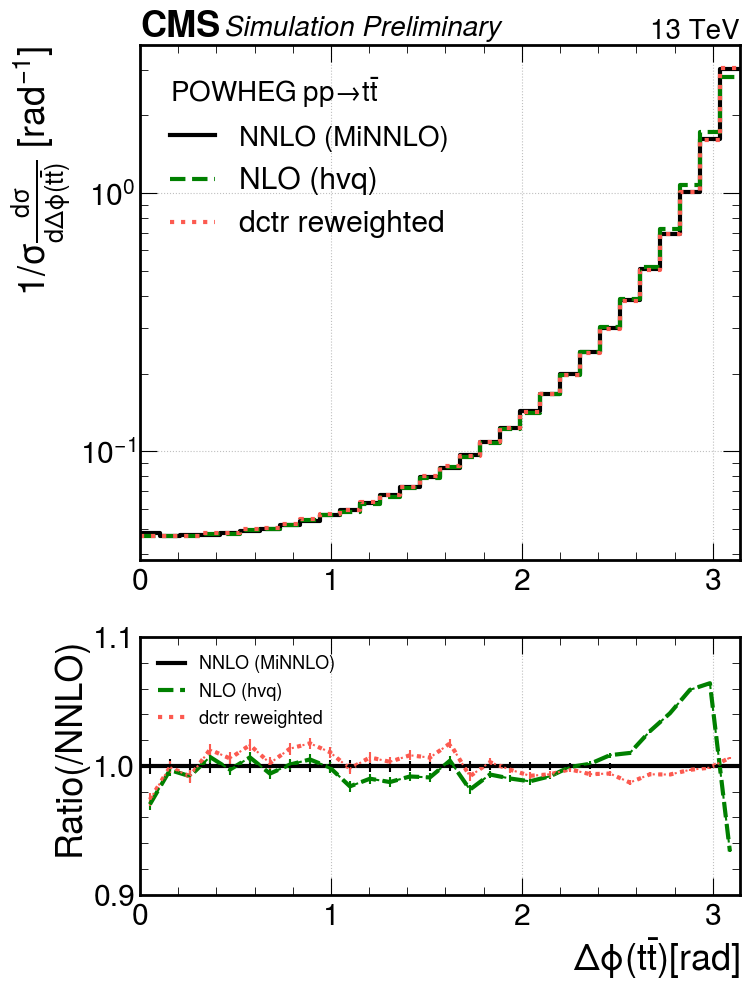

In [16]:
# delta phi
X0_delta_phi = DCTR.delta_phi(X0_plt)
X1_delta_phi = DCTR.delta_phi(X1_plt)

args_delta_phi = [(X1_delta_phi, X1_plt_wgt, 'NNLO (MiNNLO)'), 
                  (X0_delta_phi, X0_plt_wgt, 'NLO (hvq)'),
                  (X0_delta_phi, rwgt, 'dctr reweighted')]

DCTR.plot_ratio_cms(args_delta_phi, start = 0, stop = math.pi, div=31, part_label=r't \bar{t}', arg_label=r'\Delta \phi', unit='[rad]', inv_unit='[rad$^{-1}$]', y_scale='log', save_prefix='no-mean_lin_pi_31')


In [17]:
# find min values for E and m
min_E_tt = min(X1_plt[:, 0,5]) # min E tt (NNLO)
print(min_E_tt)

min_E_t = min(X1_plt[:, 1,5]) # min E t  (NNLO)
print(min_E_t)

min_m_tt = min(X1_plt[:, 0,3]) # min m tt (NNLO)
print(min_m_tt)


329.6132055
159.6472363
322.9727283915917


'texgyreheros-bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-italic.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


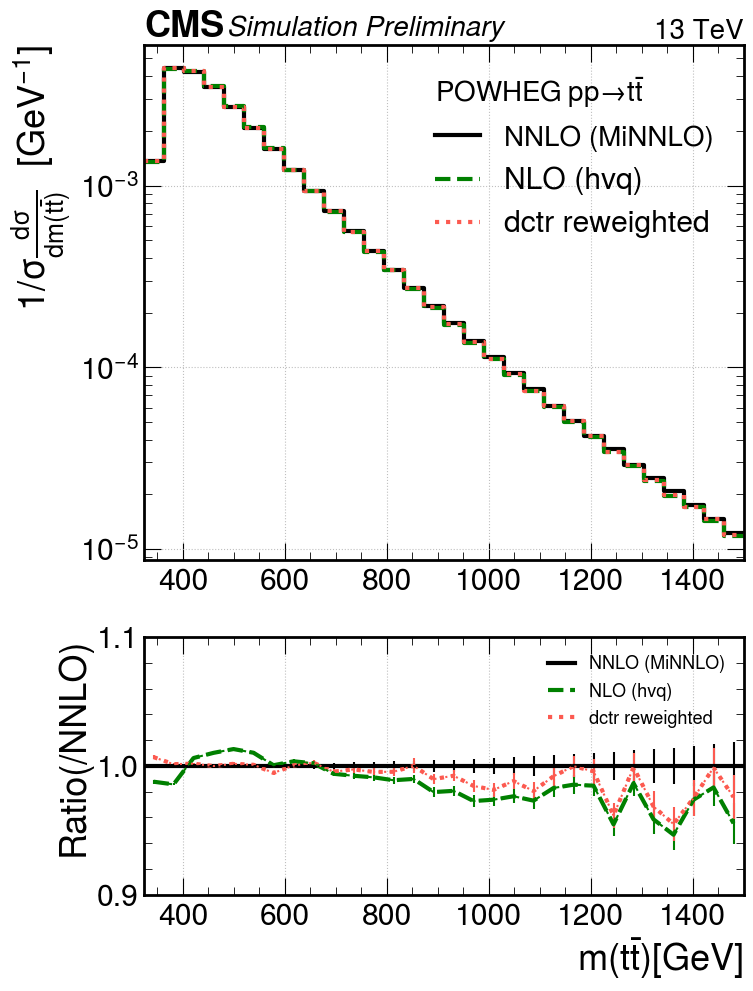

In [18]:
# m(tt) min(X1[:,])
lin_bins = np.linspace(min_m_tt, 1500, 31)
DCTR.plot_ratio_cms(args, arg_index=3, part_index=0, bins=lin_bins, y_scale='log', ratio_ylim=[0.90, 1.10], pythia_text=r'$POWHEG \; pp \to  t\bar{t}$', save_prefix = 'no-mean_lin_min-1500_31')
